In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import DicomPipeLine 

In [3]:
main_data_source_path = r'/app/Data Pipeline/DataBase_1'
preprocessed_data_path = r'/app/Data Pipeline/TestDataBase_2'
sub_folders_to_scan_for = ['2','3','4','5']

In [4]:
main_data_source_path = r'F:\Final Year Project\Data Pipeline\DataBase_1'
preprocessed_data_path = r'F:\Final Year Project\Data Pipeline\TestDataBase_2'
sub_folders_to_scan_for = ['2','3','4','5']

In [5]:
path_obj = DicomPipeLine.Path_Settings(main_data_source_path, preprocessed_data_path, sub_folders_to_scan_for)

In [6]:
streamer = DicomPipeLine.Stream_Data(path_obj)

In [7]:
ct_array = streamer.get('1', 'CT PLAIN')
pet_array = streamer.get('1', 'PET WB  (AC)')

F:\Final Year Project\Data Pipeline\TestDataBase_2\1\CT PLAIN.pickle.gzip
F:\Final Year Project\Data Pipeline\TestDataBase_2\1\PET WB  (AC).pickle.gzip


In [8]:
ct = ct_array[362]
pt = pet_array[362]

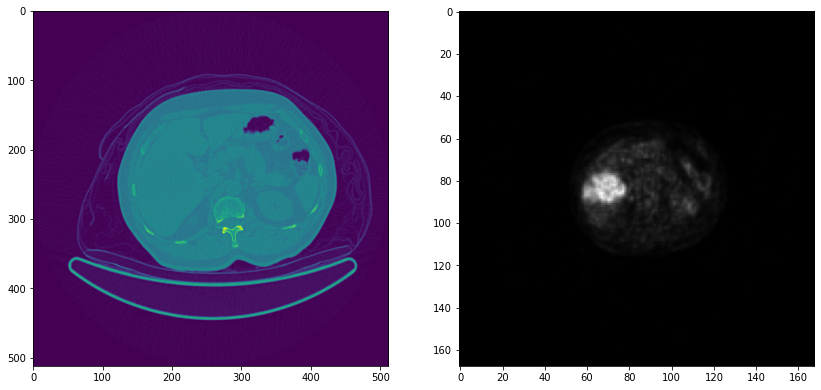

In [9]:
%matplotlib inline
plt.figure(figsize = (14,14))
plt.subplot(1,2,1)
plt.imshow(ct)
plt.subplot(1,2,2)
plt.imshow(pt, cmap = 'gray')

In [10]:
def NORMALIZE(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype = cv2.CV_8U)

In [11]:
%matplotlib inline
def PLOT(img, cmap, f_size):
    plt.figure(figsize = f_size)
    plt.imshow(img, cmap = cmap)

In [12]:
from skimage.transform import resize

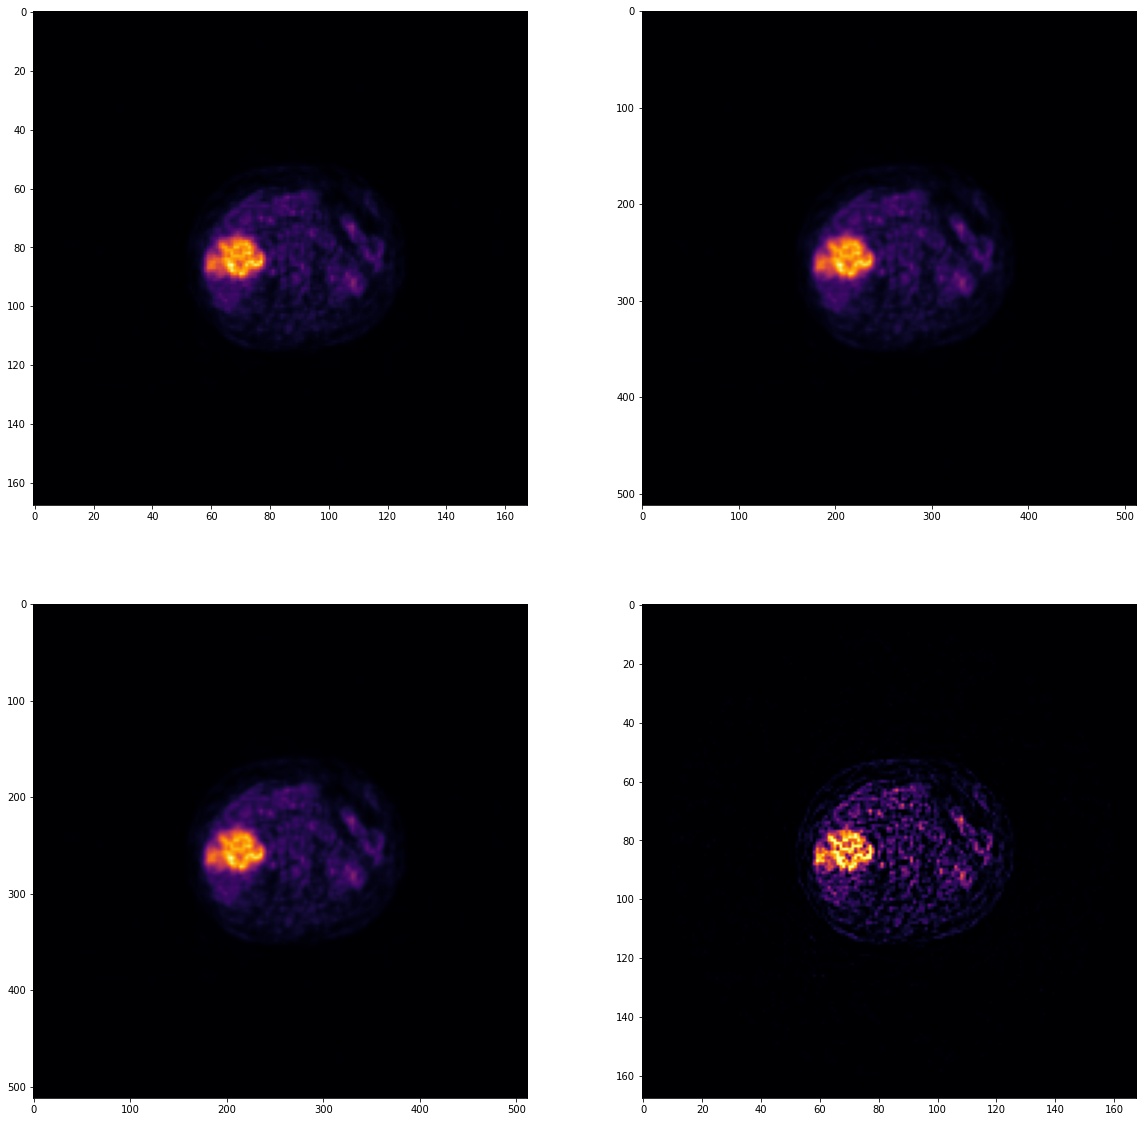

In [13]:
pt = NORMALIZE(pt)
test_img_t = resize(pt, (ct.shape[0], ct.shape[1]),anti_aliasing=True)
test_img_f = resize(pt, (ct.shape[0], ct.shape[1]),anti_aliasing=False)
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
test_img_s = cv2.filter2D(src=pt, ddepth=-1, kernel=kernel)
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.imshow(pt, cmap = 'inferno')
plt.subplot(2,2,2)
plt.imshow(test_img_t, cmap = 'inferno')
plt.subplot(2,2,3)
plt.imshow(test_img_f, cmap = 'inferno')
plt.subplot(2,2,4)
plt.imshow(test_img_s, cmap = 'inferno')

In [14]:
num_pts = 5

In [15]:
%matplotlib notebook
def Interactive_Plot(a_args, b_args, num_pts, fig_size):
    
    img_a, cmap_a = a_args
    img_b, cmap_b = b_args
    
    a_pts = []
    b_pts = []
    
    fig = plt.figure(figsize = fig_size)
    a = fig.add_subplot(121)
    a.imshow(img_a, cmap = cmap_a)
    b = fig.add_subplot(122)
    b.imshow(img_b, cmap = cmap_b)
    
    def onclick(event):
        if event.inaxes == a:
            if event.button == 1:
                if len(a_pts) < num_pts:
                    a_pts.append((int(event.xdata), int(event.ydata)))
                    a.text(0, 0, f"{a_pts}", va="bottom", ha="left")
        elif event.inaxes == b:
            if event.button == 1:
                if len(b_pts) < num_pts:
                    b_pts.append((int(event.xdata), int(event.ydata)))
                    b.text(0, 0, f"{b_pts}", va="bottom", ha="left")
                
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    return a_pts, b_pts

<IPython.core.display.Javascript object>


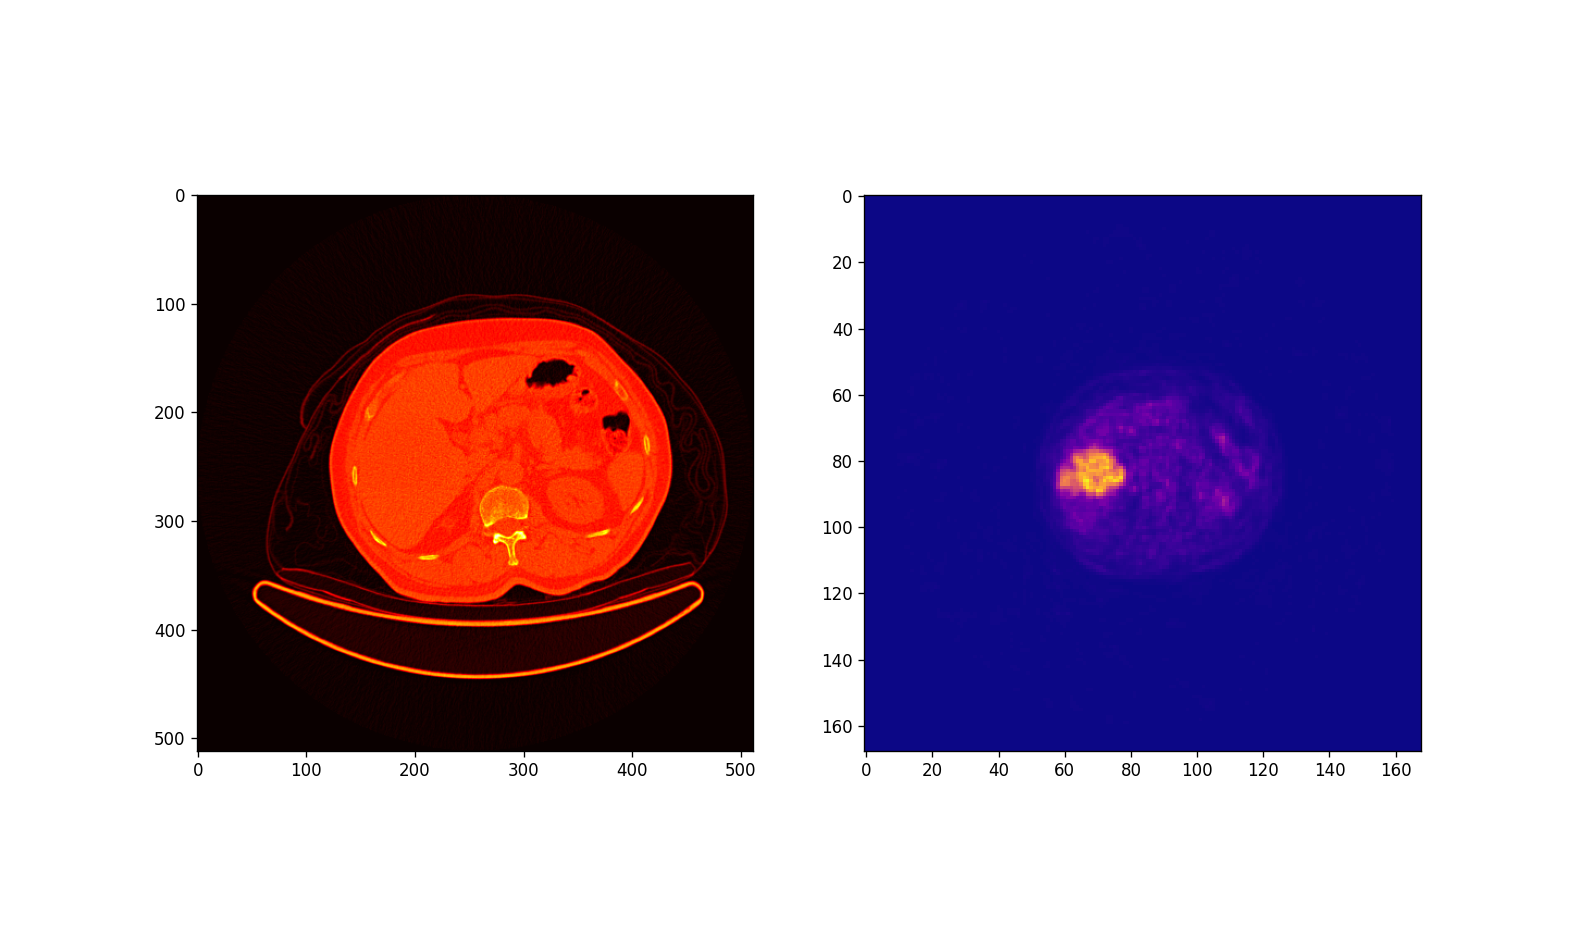

In [16]:
ct_arguments = (ct, 'hot')
pt_arguments = (pt, 'plasma')
num_pts = 5
figure_size = (8, 8)
ct_pts, pt_pts = Interactive_Plot(ct_arguments, pt_arguments, num_pts, figure_size)

In [23]:
ct_pts = np.asarray(ct_pts)
ct_pts

array([[260, 113],
       [119, 238],
       [434, 238],
       [291, 357],
       [190, 320]])

In [24]:
pt_pts = np.asarray(pt_pts)
pt_pts

array([[ 85,  52],
       [ 51,  83],
       [125,  84],
       [ 91, 110],
       [ 67, 101]])

In [25]:
streamer.save_transform_points('1', ct, pt, ct_pts, pt_pts)

In [16]:
ct_frames, pt_frames = streamer.get_scans('1', 'CT PLAIN', 'PET WB  (AC)', transform = True)

F:\Final Year Project\Data Pipeline\TestDataBase_2\1\CT PLAIN.pickle.gzip
F:\Final Year Project\Data Pipeline\TestDataBase_2\1\PET WB  (AC).pickle.gzip


In [17]:
import pywt

In [18]:
def fuseCoeff(cooef1, cooef2, method):

    if (method == 'mean'):
        cooef = (cooef1 + cooef2) / 2
    elif (method == 'min'):
        cooef = np.minimum(cooef1,cooef2)
    elif (method == 'max'):
        cooef = np.maximum(cooef1,cooef2)
    else:
        cooef = []

    return cooef

In [19]:
def Fusion_Method_1(img_a, img_b):
    
    # Params
    FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

    # Read the two image
    I2 = img_a
    I1 = img_b

    # We need to have both images the same size
    # I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images

    ## Fusion algo

    # First: Do wavelet transform on each image
    wavelet = 'haar'
    cooef1 = pywt.wavedec2(I1[:,:], wavelet)
    cooef2 = pywt.wavedec2(I2[:,:], wavelet)
    # print(cooef1)
    # print(cooef2)

    # Second: for each level in both image do the fusion according to the desire option
    fusedCooef = []
    for i in range(len(cooef1)-1):

        # The first values in each decomposition is the apprximation values of the top level
        if(i == 0):

            fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))

        else:

            # For the rest of the levels we have tupels with 3 coeeficents
            c1 = fuseCoeff(cooef1[i][0], cooef2[i][0], FUSION_METHOD)
            c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
            c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)

            fusedCooef.append((c1,c2,c3))

    # Third: After we fused the cooefficent we need to transfor back to get the image
    fusedImage = pywt.waverec2(fusedCooef, wavelet)

    # Forth: normmalize values to be in uint8
    fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
    fusedImage = fusedImage.astype(np.uint8)

    return fusedImage

In [35]:
cv2.namedWindow('Fusion method 1',cv2.WINDOW_NORMAL)
cv2.resizeWindow('Fusion method 1', 600,600)

kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])

# ct_slice = ct_frames[294:413]
# pt_slice = pt_frames[294:413]

i = 294
while i >= 0 and i < len(ct):
    
#     print(i)
    
    ct = NORMALIZE(ct_frames[i])
    pt = NORMALIZE(pt_frames[i])
    
    pt = cv2.filter2D(src = pt, ddepth=0, kernel=kernel)
    fused_frame = Fusion_Method_1(ct, pt)
#     fused_frame = cv2.filter2D(src = fused_frame, ddepth=0, kernel=kernel)
    
    cv2.imshow('Fusion method 1', fused_frame)
    
    
    current_key = cv2.waitKey(0)
    if current_key & 0xFF == ord('b'):
        i -= 1
        continue
    if current_key & 0xFF == ord('q'):
        break
    i += 1
    
    
cv2.destroyAllWindows()

294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413


In [29]:
# import registration

In [19]:
# t_obj = registration.TransFormation(ct, pt, ct_pts, pt_pts)

In [20]:
# t_obj.info()

In [21]:
# img_tr = t_obj.transform(pt)

In [22]:
# PLOT(img_tr, 'inferno', (6, 6))

In [23]:
# cmap = plt.get_cmap('inferno')
# img_tr = NORMALIZE(img_tr)
# img_tr_inferno = cmap(img_tr)

# cv2.imshow('inferno', img_tr_inferno)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# img_tr_inferno = (img_tr_inferno[:, :, :1] * 255).astype(np.uint8)

# cv2.imshow('inferno', img_tr_inferno)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# plt.imshow(img_tr_inferno)

In [ ]:
def cmap_rgb(img):
    img = cmap(img)
    return (img[:, :, :3] * 255).astype(np.uint8)

In [ ]:
ct_frames = streamer.get('2', 'CT PLAIN')
pt_frames = streamer.get('2', 'PET WB  (AC)')


In [ ]:
for ct, pt in zip(ct_frames, pt_frames):
    
    pt = t_obj.transform(pt)
    
    ct = NORMALIZE(ct)              
    pt = NORMALIZE(pt)
    
    cv2.imshow('CT Image', ct)
    cv2.imshow('PET Image', pt)
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
        
cv2.destroyAllWindows()

In [20]:
import pywt

In [21]:
# This function does the coefficient fusing according to the fusion method
def fuseCoeff(cooef1, cooef2, method):

    if (method == 'mean'):
        cooef = (cooef1 + cooef2) / 2
    elif (method == 'min'):
        cooef = np.minimum(cooef1,cooef2)
    elif (method == 'max'):
        cooef = np.maximum(cooef1,cooef2)
    else:
        cooef = []

    return cooef

In [22]:

def Fusion_Method_1(img_a, img_b):
    
    # Params
    FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

    # Read the two image
    I2 = img_a
    I1 = img_b

    # We need to have both images the same size
    # I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images

    ## Fusion algo

    # First: Do wavelet transform on each image
    wavelet = 'haar'
    cooef1 = pywt.wavedec2(I1[:,:], wavelet)
    cooef2 = pywt.wavedec2(I2[:,:], wavelet)
    # print(cooef1)
    # print(cooef2)

    # Second: for each level in both image do the fusion according to the desire option
    fusedCooef = []
    for i in range(len(cooef1)-1):

        # The first values in each decomposition is the apprximation values of the top level
        if(i == 0):

            fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))

        else:

            # For the rest of the levels we have tupels with 3 coeeficents
            c1 = fuseCoeff(cooef1[i][0], cooef2[i][0], FUSION_METHOD)
            c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
            c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)

            fusedCooef.append((c1,c2,c3))

    # Third: After we fused the cooefficent we need to transfor back to get the image
    fusedImage = pywt.waverec2(fusedCooef, wavelet)

    # Forth: normmalize values to be in uint8
    fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
    fusedImage = fusedImage.astype(np.uint8)

    return fusedImage

In [21]:
ct_frames = streamer.get('1', 'CT PLAIN')
pt_frames = streamer.get('1', 'PET WB  (AC)')

F:\Final Year Project\Data Pipeline\TestDataBase_2\1\CT PLAIN.pickle.gzip
F:\Final Year Project\Data Pipeline\TestDataBase_2\1\PET WB  (AC).pickle.gzip


In [23]:
import DicomPipeLine

In [18]:
ct_frames, pt_frames = streamer.get_scans('1', 'CT PLAIN', 'PET WB  (AC)', transform = True)

F:\Final Year Project\Data Pipeline\TestDataBase_2\1\CT PLAIN.pickle.gzip
F:\Final Year Project\Data Pipeline\TestDataBase_2\1\PET WB  (AC).pickle.gzip


%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))
text=ax.text(0,0, "", va="bottom", ha="left")

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)

cid = fig.canvas.mpl_connect('button_press_event', onclick)